In [96]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

from copy import deepcopy
from sklearn import linear_model
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr, spearmanr, kendalltau 
from scipy import stats

from robustDA import process_cmip6, processing, anchor_regression, plots, parse_args

%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [97]:
params_climate = {
        "temporalRes": "ann",
        "variables": ["tas"],
        "scenarios": ["historical", "piControl"],
        "startDate": 1850,
        "endDate": 2014,
        "target": "aerosols",
        "anchor": "co2",
    }

params_anchor = {
        "gamma": 1000,
        "h_anchors": ["square"],
    }

In [108]:
# X, y, y_anchor, Xt, yt, yt_anchor, std_X_train = anchor_regression.standardize(dict_models)

A_h = np.zeros((y_anchor.shape[0], len(h_anchors) + 1))
A_h[:, 0] = y_anchor.reshape(-1)

if len(h_anchors) > 0:
    for i in range(len(h_anchors)):
        A_h[:, i + 1] = anchor_regression.helpers.nonlinear_anchors(
            y_anchor, h_anchors[i]
        ).reshape(-1)

A_h = np.mat(A_h)  # needed for matrix multiplication

# PA = A_h * np.linalg.inv(np.transpose(A_h) * A_h) * np.transpose(A_h)
# #     A_h_std = np.mat(StandardScaler().fit_transform(A_h))
# #     PA = (
# #         A_h_std
# #         * np.linalg.inv(np.transpose(A_h_std) * A_h_std)
# #         * np.transpose(A_h_std)
# #     )

In [110]:
AtA = np.transpose(A_h) * A_h

In [115]:
np.linalg.inv(AtA)

matrix([[ 2.77038015e-04, -9.28694395e-05],
        [-9.28694395e-05,  6.05848637e-05]])

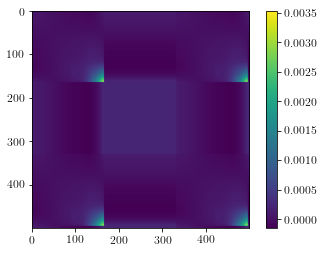

In [122]:
PA = A_h * np.linalg.inv(np.transpose(A_h) * A_h) * np.transpose(A_h)
plt.imshow(PA[:500, :500])
plt.colorbar()

In [135]:
A_h_std = np.mat(StandardScaler(with_mean=True, with_std=True).fit_transform(A_h))
AtA_std = np.transpose(A_h_std) * A_h_std

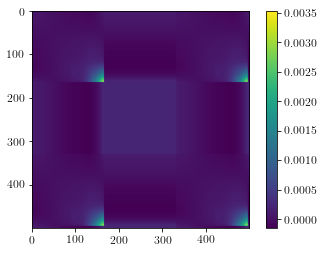

In [123]:
PA_std = A_h_std * np.linalg.inv(np.transpose(A_h_std) * A_h_std) * np.transpose(A_h_std)
plt.imshow(PA[:500, :500])
plt.colorbar()

In [130]:
PA[:3,:3]

matrix([[7.06825995e-05, 6.97273985e-05, 6.86832821e-05],
        [6.97273985e-05, 6.87852167e-05, 6.77553288e-05],
        [6.86832821e-05, 6.77553288e-05, 6.67409910e-05]])

In [129]:
PA_std[:3,:3]

matrix([[2.78603569e-05, 2.77453308e-05, 2.76182650e-05],
        [2.77453308e-05, 2.76510086e-05, 2.75465590e-05],
        [2.76182650e-05, 2.75465590e-05, 2.74668147e-05]])

In [141]:
np.sum(np.sum(PA-PA_std))

3340.0814005213724

### Param optimization all gamma

In [90]:
import pickle
filename = ("./../output/data/param_optimization_target_" + params_climate["target"]
            + "_" + "anchor_" + params_climate["anchor"] + "_" + "-".join(params_climate["variables"])
            + "_" + "-".join(params_climate["scenarios"]) + "_" + str(params_climate["startDate"])
            + "_" + str(params_climate["endDate"]) + "_"  
            + "nonlinear-h_" + str(len(params_anchor["h_anchors"])) + "-".join(params_anchor["h_anchors"]) 
            + "_Ahstd.pkl")
with open(filename, 'rb') as f:
    mse_gamma, corr_gamma, mi_gamma, gamma_vals, h_anchors, cv_vals, dict_models = pickle.load(f)

IndexError: index 0 is out of bounds for axis 1 with size 0

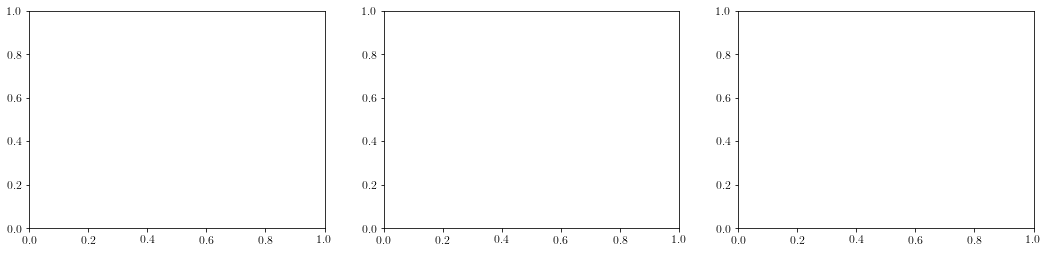

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

k=1
mse_gamma = mse_gamma[:,1:2,:-k]
corr_gamma = corr_gamma[:,1:2,:-k]
mi_gamma = mi_gamma[:,1:2,:-k]
gamma_vals = gamma_vals[:]
lambdavals = np.logspace(-2, 5, cv_vals)
lambdavals = lambdavals[:-k]
for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax1.plot(mse_gamma[i,j,:], corr_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax1.set_xscale('log')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr')        
ax1.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax2.plot(mse_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
# ax2.set_xscale('log')
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')        
ax2.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax3.plot(corr_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = [" + "-".join(h_anchors[:j]) + "]")
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')        
ax3.legend();

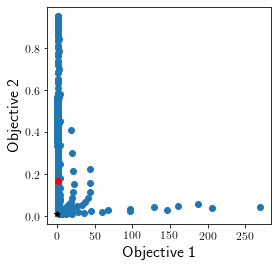

Gamma = 10
h_anchors = 
Lambda = 26.826957952797247


In [93]:
fig = plt.figure(figsize = (4,4))
gammaSel, hSel, lambdaSel, pf_X, pf_Y = anchor_regression.choose_gamma_h_lambda_pareto(mse_gamma, corr_gamma, 
                                             gamma_vals, h_anchors, lambdavals, maxX=False, maxY=False)
print("Gamma = " + str(gammaSel)) 
print("h_anchors = " + "-".join(hSel))
print("Lambda = " + str(lambdaSel))

In [65]:
hSel = ["square"]
anchor_regression.anchor_regression(dict_models, gammaSel, hSel, lambdaSel, params_climate)

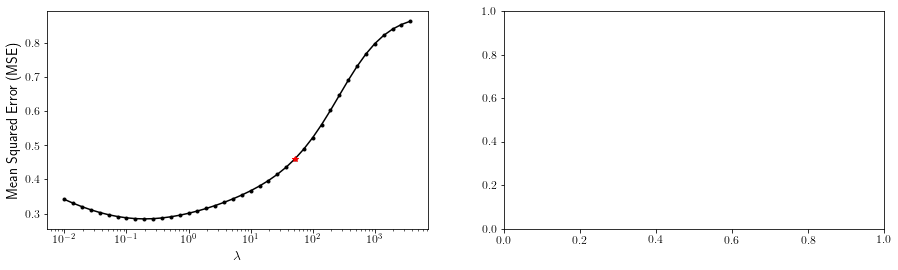

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

mse_total = mse_gamma[-1,:,:].reshape(-1, 1)
ax1.plot(lambdavals, mse_total, "k.-")

ax1.set_xscale("log")
# ax1.set_yscale("log")
ax1.set_ylabel("Mean Squared Error (MSE)", fontsize=14)
ax1.set_xlabel("$\\lambda$", fontsize=14)

ind = [i for i in range(len(lambdavals)) if lambdavals[i] == lambdaSel]
ax1.plot(lambdaSel, mse_total[ind], 'r*')

In [57]:
ind = [i for i in range(len(lambdavals)) if lambdavals[i] == lambdaSel]

In [58]:
ind

[22]

In [98]:
modelsDataList, modelsInfoFrame = process_cmip6.read_files_cmip6(params_climate)

modelsInfoFrame.head()

,filename,var,temporalRes,modelFull,model,scenario,spatialRes
0,tas_ann_ACCESS-CM2_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,historical,g025
1,tas_ann_ACCESS-CM2_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-CM2,ACC,piControl,g025
2,tas_ann_ACCESS-ESM1-5_historical_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,historical,g025
3,tas_ann_ACCESS-ESM1-5_piControl_r1i1p1f1_g025.nc,tas,ann,ACCESS-ESM1-5,ACC,piControl,g025
4,tas_ann_AWI-CM-1-1-MR_historical_r1i1p1f1_g025.nc,tas,ann,AWI-CM-1-1-MR,AWI,historical,g025


In [99]:
dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

print(dict_models['trainModels'])
print(dict_models['testModels'])

['ACC' 'CAM' 'CAS' 'CES' 'CMC' 'FGO' 'GFD' 'GIS' 'IIT' 'IPS' 'KIO' 'MRI'
 'SAM' 'Tai']
['AWI' 'BCC' 'CIE' 'Can' 'E3S' 'EC-' 'FIO' 'INM' 'MCM' 'MIR' 'MPI' 'NES'
 'Nor']


In [100]:
X_train = dict_models["X_train"]
y_train = dict_models["y_train"]
y_anchor_train = dict_models["y_anchor_train"]

X_test = dict_models["X_test"]
y_test = dict_models["y_test"]
y_anchor_test = dict_models["y_anchor_test"]

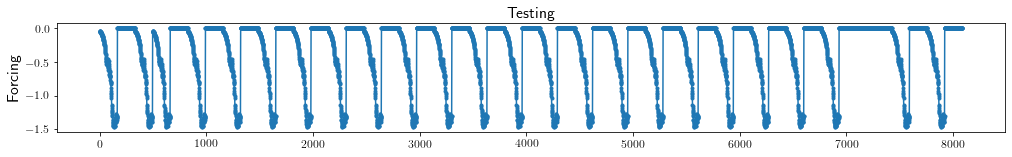

In [101]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_test.values, '.-')
plt.ylabel("Forcing")
plt.title("Testing");

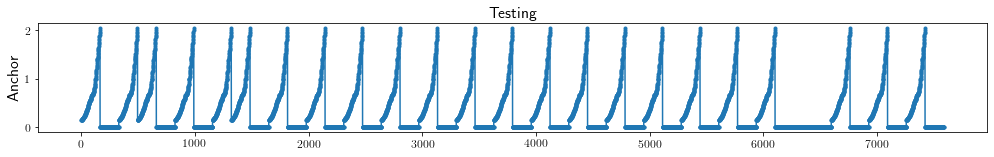

In [7]:
fig = plt.figure(figsize = (17,2))
plt.plot(y_anchor_test.values, '.-')
plt.ylabel("Anchor")
plt.title("Testing");

In [8]:
gamma = params_anchor["gamma"]
h_anchors = params_anchor["h_anchors"]

target = params_climate["target"]
anchor = params_climate["anchor"]

In [9]:
lambdaSel, mse_df, corr_pearson, mi = anchor_regression.cross_validation_anchor_regression(
    modelsDataList,
    modelsInfoFrame,
    deepcopy(dict_models),
    params_climate,
    gamma,
    h_anchors,
    30,
    display_CV_plot=True)

MemoryError: Unable to allocate 600. MiB for an array with shape (7590, 10368) and data type float64

In [ ]:
lambdaSel

In [ ]:
anchor_regression.anchor_regression(
        dict_models, gamma, h_anchors, lambdaSel, params_climate, 10
    )

### Param optimization

In [213]:
import pickle
filename = ("./../output/data/param_optimization_gamma_target_" + params_climate["target"]
            + "_" + "anchor_" + params_climate["anchor"] + "_" + "-".join(params_climate["variables"])
            + "_" + "-".join(params_climate["scenarios"]) + "_" + str(params_climate["startDate"])
            + "_" + str(params_climate["endDate"]) + "_" + "gamma_" + str(params_anchor["gamma"]) + "_" 
            + "nonlinear-h_" + str(len(params_anchor["h_anchors"])) + "-".join(params_anchor["h_anchors"]) + ".pkl")
with open(filename, 'rb') as f:
    mse_df, corr_pearson, mi, gamma, h_anchors = pickle.load(f)

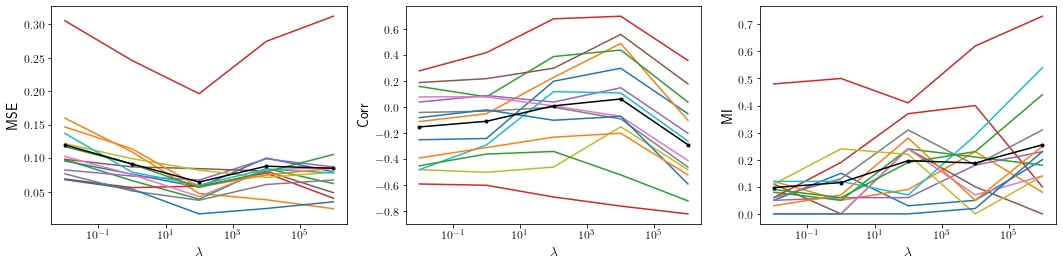

In [246]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

cv_vals = mse_df.index

nbStd = np.array([1, 2, 3])
clr = ["r", "b", "k"]

for i in range(mse_df.shape[1] - 1):
    ax1.plot(mse_df.index, mse_df.iloc[:, i], label="_nolegend_")

ax1.plot(mse_df.index, mse_df.iloc[:, i + 1], "k.-")
ax1.set_xscale("log")
# ax1.set_yscale("log")
ax1.set_xlabel("$\\lambda$", fontsize=14)
ax1.set_ylabel("MSE", fontsize=14)

for j in range(corr_pearson.shape[1]):
    ax2.plot(cv_vals, corr_pearson[:, j], label="_nolegend_")

ax2.plot(cv_vals, np.mean(corr_pearson, axis = 1), "k.-")
ax2.set_xscale("log")
# ax1.set_yscale("log")

ax2.set_xlabel("$\\lambda$", fontsize=14)
ax2.set_ylabel("Corr", fontsize=14)

        
for j in range(mi.shape[1]):
    ax3.plot(cv_vals, mi[:, j], label="_nolegend_")

ax3.plot(cv_vals, np.mean(mi, axis = 1), "k.-")
ax3.set_xscale("log")
# ax1.set_yscale("log")

ax3.set_xlabel("$\\lambda$", fontsize=14)
ax3.set_ylabel("MI", fontsize=14);

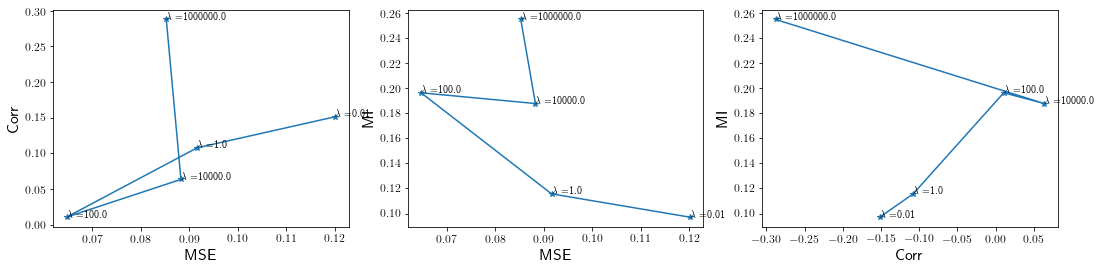

In [261]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

mse_mean = mse_df.iloc[:,-1].values
corr_mean = np.mean(corr_pearson, axis = 1)
mi_mean = np.mean(mi, axis = 1)

k = 1
ax1.plot(mse_df.iloc[:,-1].values, np.abs(np.mean(corr_pearson, axis = 1)), "*-")
for i in range(mse_df.shape[0]):
    ax1.text(mse_mean[i], np.abs(corr_mean[i]), "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr') 
# ax1.set_xscale("log")

ax2.plot(mse_df.iloc[:,-1].values, np.mean(mi, axis = 1), "*-")
for i in range(mse_df.shape[0]):
    ax2.text(mse_mean[i], mi_mean[i], "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')     
# ax2.set_xscale("log")

ax3.plot(np.mean(corr_pearson, axis = 1), np.mean(mi, axis = 1), "*-")
for i in range(mse_df.shape[0]):
    ax3.text(corr_mean[i], mi_mean[i], "$\lambda = $" + str(np.round(cv_vals[i], 2)))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')   ;     

In [227]:
def compute_distance(ideal, pf_X, pf_Y):
    d = np.zeros([len(pf_X), 1])
    for i in range(len(pf_X)):
        d[i] = np.sqrt(0.5*(ideal[0] - pf_X[i])**2 + 0.5*(ideal[1] - pf_Y[i])**2)
    return d
        
def plot_pareto_frontier(Xs, Ys, lambdavals, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
#     '''Plotting process'''
#     plt.scatter(Xs,Ys)
#     pf_X = [pair[0] for pair in pareto_front]
#     pf_Y = [pair[1] for pair in pareto_front]
#     plt.plot(pf_X, pf_Y)
#     plt.xlabel("Objective 1")
#     plt.ylabel("Objective 2")
    
    ideal = [min(Xs), min(Ys)]
    dst = compute_distance(ideal, pf_X, pf_Y)
    ind = np.argmin(dst)
    lambdaSel = [lambdavals[i] for i in range(len(lambdavals)) if (Xs[i] == pf_X[ind]) and (Ys[i] == pf_Y[ind])]
#     plt.plot(ideal[0], ideal[1], "k*")
#     plt.plot(pf_X[ind], pf_Y[ind], "ro")
#     plt.show()
    
    return lambdaSel, pf_X, pf_Y

[56.89866029018293]


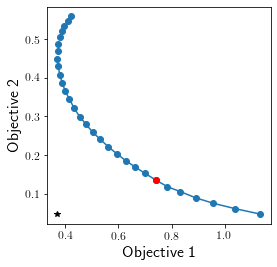

In [229]:
fig = plt.figure(figsize = (4,4))
k = 20
Xs = mse_df.iloc[:,-1].values[:-k]
lambdavals = mse_df.index[:-k]
Ys = np.abs(np.mean(corr_pearson, axis = 1)[:-k])
pf_X, pf_Y = plot_pareto_frontier(Xs, Ys, lambdavals, maxX=False, maxY=False)

In [205]:
lambdaSel = [lambdavals[i] for i in range(len(lambdavals)) if (Xs[i] == pf_X[ind]) and (Ys[i] == pf_Y[ind])]

In [206]:
lambdaSel

[56.89866029018293]

In [204]:
ideal = [min(Xs), min(Ys)]
dst = compute_distance(ideal, pf_X, pf_Y)
ind = np.argmin(dst)
ind

12

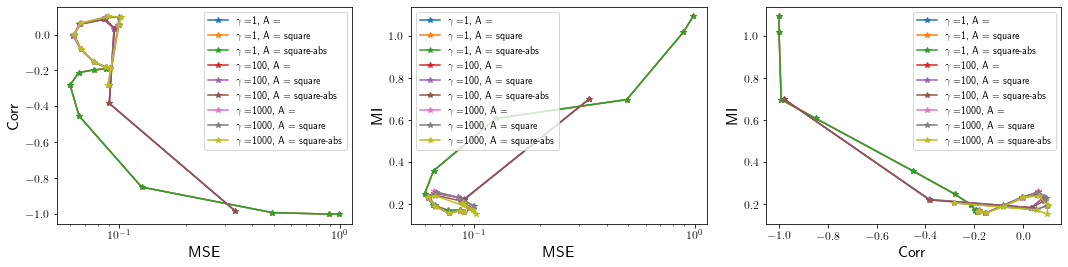

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax1.plot(mse_gamma[i,j,:], corr_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = " + "-".join(h_anchors[:j]))
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax1.set_xscale('log')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Corr')        
ax1.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax2.plot(mse_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = " + "-".join(h_anchors[:j]))
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax2.set_xscale('log')
ax2.set_xlabel('MSE')
ax2.set_ylabel('MI')        
ax2.legend();

for i in range(mse_gamma.shape[0]):
    for j in range(mse_gamma.shape[1]):
        ax3.plot(corr_gamma[i,j,:], mi_gamma[i,j,:], ".-", marker = "*", 
                 label = "$\gamma = $" + str(gamma_vals[i]) + ", A = " + "-".join(h_anchors[:j]))
#     for j in range(mse_gamma.shape[1]):
#         plt.text(mse_gamma[i,j], corr_gamma[i,j], "$\lambda = $" + str(lambdaCV[j]))
ax3.set_xlabel('Corr')
ax3.set_ylabel('MI')        
ax3.legend();

No handles with labels found to put in legend.


Text(0.5, 0, '$\\lambda$')

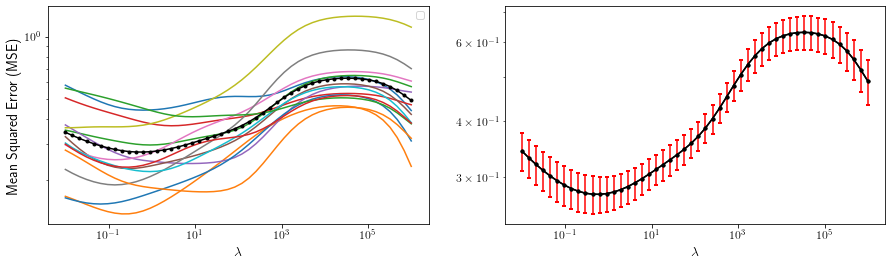

In [16]:
nbStd = np.array([1, 2, 3])
clr = ["r", "b", "k"]

sem_CV = np.zeros(mse_df.shape[0])
for i in range(mse_df.shape[0]):
    sem_CV[i] = stats.sem(mse_df.iloc[i, :-1], ddof=0)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

for i in range(mse_df.shape[1] - 1):
    ax1.plot(mse_df.index, mse_df.iloc[:, i], label="_nolegend_")

ax1.plot(mse_df.index, mse_df.iloc[:, i + 1], "k.-")

# ax1.axvline(
#     lambdasSelAll[0],
#     ls="--",
#     color="k",
#     label="$\\lambda_{opt}$ = " + str(np.round(lambdasSelAll[0], 2)),
# )

# for j in range(len(lambdasSelAll) - 1):
#     ax1.axvline(
#         lambdasSelAll[j + 1],
#         color=clr[j],
#         label="$\\lambda_{"
#         + str(nbStd[j])
#         + " SEM} $ = "
#         + str(np.round(lambdasSelAll[j + 1], 2)),
#     )
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("Mean Squared Error (MSE)", fontsize=14)
ax1.set_xlabel("$\\lambda$", fontsize=14)
ax1.legend(fontsize=10)

ax2.plot(mse_df.index, mse_df["MSE - TOTAL"], "k.-")
ax2.errorbar(
    mse_df.index,
    mse_df["MSE - TOTAL"],
    yerr=sem_CV,
    fmt="k.-",
    ecolor="r",
    capsize=2,
    capthick=2,
)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$\\lambda$", fontsize=14)

In [70]:
coefRaw, y_test_pred, mse = anchor_regression.anchor_regression_estimator(
        dict_models, gamma, h_anchors, lambdasSelAll[2]
    )
plots.make_plots(        dict_models,
        coefRaw,
        y_test_pred,
        dict_models["y_anchor_test"],
        gamma,
        params_climate["target"],
        params_climate["anchor"],
        h_anchors,)

In [151]:
lambdaSel = lambdasSelAll[1]
coefRaw, y_test_pred = anchor_regression.anchor_regression(dict_models, params_anchor, lambdaSel, method = "direct")

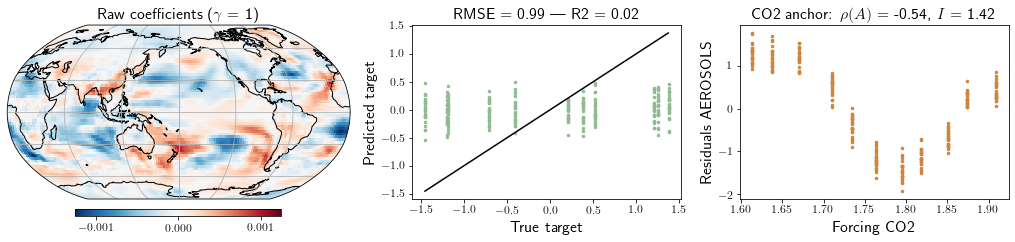

In [152]:
plots.make_plots(dict_models,coefRaw,y_test_pred,dict_models["y_anchor_test"],gamma,target,anchor,filename)

In [33]:
lambdasCV = np.logspace(-2, 6, 20)
mse = np.zeros([len(lambdasCV), len(dict_models["trainModels"])])
coefs_runs = np.zeros([5, 72*144])

uniqueTrain = set(
        [
            dict_models["trainFiles"][i].split("_")[2][:3]
            for i in range(len(dict_models["trainFiles"]))
        ]
    )

dict_folds = processing.split_folds_CV(
        modelsDataList,
        modelsInfoFrame,
        dict_models,
        params_climate["target"],
        params_climate["anchor"],
        nbFoldsCV=len(uniqueTrain),
        displayModels=False,
    )

nbFoldsCV = len(dict_folds["foldsData"])
mse = np.zeros([len(lambdasCV), nbFoldsCV])

for i in range(nbFoldsCV):
    X_val_df = dict_folds["foldsData"][i]
    y_val_df = dict_folds["foldsTarget"][i]
    y_anchor_val_df = dict_folds["foldsAnchor"][i]

    X_train_CV_df = pd.DataFrame()
    y_train_CV_df = pd.DataFrame()
    y_anchor_train_CV_df = pd.DataFrame()

    for j in range(nbFoldsCV):
        if j != i:
            X_train_CV_df = pd.concat(
                    [X_train_CV_df, dict_folds["foldsData"][j]], axis=0
                )
            y_train_CV_df = pd.concat(
                    [y_train_CV_df, dict_folds["foldsTarget"][j]], axis=0
                )
            y_anchor_train_CV_df = pd.concat(
                    [y_anchor_train_CV_df, dict_folds["foldsAnchor"][j]],
                    axis=0,
                )

    dict_models_CV = {
            #             "trainModels": trainModels,
            #             "testModels": testModels,
            #             "trainFiles": trainFiles,
            #             "testFiles": testFiles,
            "X_train": X_train_CV_df,
            "y_train": y_train_CV_df,
            "y_anchor_train": y_anchor_train_CV_df,
            "X_test": X_val_df,
            "y_test": y_val_df,
            "y_anchor_test": y_anchor_val_df,
        }

    (
        X,
            y,
            y_anchor,
            X_val,
            y_val_true,
            y_anchor_val,
            std_X_train,
        ) = anchor_regression.standardize(dict_models_CV)
                       
    for l in range(len(lambdasCV)):
        regr = linear_model.Ridge(alpha = X.shape[0] * lambdasCV[l] / 2)
        regr.fit(X, y)
        y_val_pred = regr.predict(X_val)
        mse[l][i] = np.mean((y_val_true - y_val_pred)**2)        

l = ["MSE - Fold " + str(i) for i in range(nbFoldsCV)]
mse_df = pd.DataFrame(mse, index = lambdasCV, columns = l)
mse_df['MSE - TOTAL'] = np.mean(mse, axis = 1)
mse_df.index.name = 'Lambda'
mse_df.head()

#mse_df.to_csv("./../output/data/MSE_rcp85_norm_train30_cv5_lambda0_5_100.csv")

,MSE - Fold 0,MSE - Fold 1,MSE - Fold 2,MSE - Fold 3,MSE - Fold 4,MSE - Fold 5,MSE - Fold 6,MSE - Fold 7,MSE - Fold 8,MSE - Fold 9,MSE - Fold 10,MSE - Fold 11,MSE - Fold 12,MSE - Fold 13,MSE - TOTAL
Lambda,,,,,,,,,,,,,,,
0.010000,0.104483,0.125353,0.079697,0.050081,0.048541,0.200238,0.159840,0.134280,0.150148,0.087220,0.073080,0.133397,0.090117,0.081738,0.108444
0.026367,0.103705,0.124406,0.079214,0.049114,0.047772,0.199538,0.157702,0.133911,0.147207,0.086512,0.072220,0.131345,0.089600,0.080950,0.107371
0.069519,0.101991,0.122257,0.078159,0.047039,0.046010,0.198053,0.152852,0.133115,0.140678,0.084874,0.070596,0.126742,0.088424,0.079210,0.105000
0.183298,0.098805,0.118245,0.076215,0.043589,0.042612,0.195689,0.143716,0.131765,0.128571,0.081607,0.068700,0.118132,0.086117,0.076108,0.100705
0.483293,0.093801,0.113026,0.073055,0.039956,0.037724,0.193636,0.131224,0.130161,0.110867,0.076258,0.068319,0.105813,0.082278,0.072157,0.094877


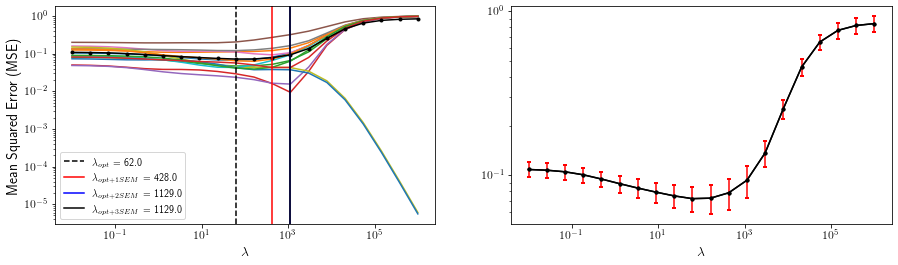

In [34]:
mse_total = mse_df['MSE - TOTAL']

nbStd = np.array([1, 2, 3])
clr = ['r', 'b', 'k']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
# suptitle = "Cross validation (ridge): " + variables[0].upper() + " -- " + target.upper() + " forcing [" + ', '.join(scenarios) + "] (" + \
#             str(startDate) + " - " + str(endDate) + ") \n"
# fig.suptitle(suptitle, fontsize = 18)

# Compute Standard error of the mean (SEM): σ_μ = σ / \sqrt{K}
stdError = np.zeros(len(lambdasCV))
for i in range(mse_df.shape[0]):
    stdError[i] = stats.sem(mse_df.iloc[i, :-1], ddof = 0) 
    
for i in range(mse_df.shape[1] - 1):
    ax1.plot(lambdasCV, mse_df.iloc[:, i], label = "_nolegend_")

ax1.plot(lambdasCV, mse_df.iloc[:, i+1], 'k.-')

lambdaOpt = mse_total[mse_total == np.min(mse_total)].index[0]
ax1.axvline(lambdaOpt, ls = '--', color = 'k', label = "$\lambda_{opt}$ = " + str(np.round(lambdaOpt)))
mse_total_sel = mse_total[lambdaOpt:]

for j in range(len(nbStd)):
# Choose the optimal lambda
    lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= np.min(mse_total_sel) + \
                     nbStd[j] * stats.sem(mse_df.loc[lambdaOpt][:-1], ddof = 0)])].index[0]
    ax1.axvline(lambdaSel, color = clr[j], label = "$\lambda_{opt + " + str(nbStd[j]) + " SEM} $ = " + \
                str(np.round(lambdaSel)))
    
# lambdaSel = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= \
#                                                                     1.1 * np.min(mse_total_sel)])].index[0]
# ax1.axvline(lambdaSel, color = 'b', label = "$\lambda_{opt} = $" + str(np.round(lambdaSel)))
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize = 14)
ax1.set_xlabel('$\lambda$', fontsize = 14);
ax1.legend(fontsize = 10);

ax2.plot(lambdasCV, mse_df['MSE - TOTAL'], 'k.-')
ax2.errorbar(lambdasCV, mse_df['MSE - TOTAL'], yerr = stdError, fmt = 'k.-', ecolor = 'r', capsize = 2, capthick = 2)  
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('$\lambda$', fontsize = 14);

### Aggregating over multiple runs

In [45]:
grid = (72, 144)
nbRuns = 20
lambdasCV = np.logspace(-2, 6, 30)
mse_runs = np.zeros([nbRuns, 1])
coefRaw_runs = np.zeros([nbRuns, grid[0]*grid[1]])
coefStd_runs = np.zeros([nbRuns, grid[0]*grid[1]])
nbStdSEM = 2
lambdaSel_runs = np.zeros([nbRuns, 1])
trainFiles = []
testFiles = []

for r in range(nbRuns):
    print("---- Run = " + str(r) + " ----")

    dict_models = processing.split_train_test(modelsDataList, modelsInfoFrame, 
                                          params_climate["target"], params_climate["anchor"])

    print(dict_models['trainModels'])
    print(dict_models['testModels'])

    trainFiles.append(dict_models["trainFiles"])
    testFiles.append(dict_models["testFiles"])
    
    # Create training and testing data for each run
    uniqueTrain = set(
            [
                dict_models["trainFiles"][i].split("_")[2][:3]
                for i in range(len(dict_models["trainFiles"]))
            ]
        )

    dict_folds = processing.split_folds_CV(
            modelsDataList,
            modelsInfoFrame,
            dict_models,
            params_climate["target"],
            params_climate["anchor"],
            nbFoldsCV=len(uniqueTrain),
            displayModels=False,
        )

    nbFoldsCV = len(dict_folds["foldsData"])
    mse_CV = np.zeros([len(lambdasCV), nbFoldsCV])

    for i in range(nbFoldsCV):
        X_val_df = dict_folds["foldsData"][i]
        y_val_df = dict_folds["foldsTarget"][i]
        y_anchor_val_df = dict_folds["foldsAnchor"][i]

        X_train_CV_df = pd.DataFrame()
        y_train_CV_df = pd.DataFrame()
        y_anchor_train_CV_df = pd.DataFrame()

        for j in range(nbFoldsCV):
            if j != i:
                X_train_CV_df = pd.concat(
                        [X_train_CV_df, dict_folds["foldsData"][j]], axis=0
                    )
                y_train_CV_df = pd.concat(
                        [y_train_CV_df, dict_folds["foldsTarget"][j]], axis=0
                    )
                y_anchor_train_CV_df = pd.concat(
                        [y_anchor_train_CV_df, dict_folds["foldsAnchor"][j]],
                        axis=0,
                    )

        dict_models_CV = {
                "X_train": X_train_CV_df,
                "y_train": y_train_CV_df,
                "y_anchor_train": y_anchor_train_CV_df,
                "X_test": X_val_df,
                "y_test": y_val_df,
                "y_anchor_test": y_anchor_val_df,
            }

        (X,
                y,
                y_anchor,
                X_val,
                y_val_true,
                y_anchor_val,
                std_X_train,
            ) = anchor_regression.standardize(dict_models_CV) 

        for l in range(len(lambdasCV)):
            regr = linear_model.Ridge(alpha = X.shape[0] * lambdasCV[l] / 2)
            regr.fit(X, y)
            y_val_pred = regr.predict(X_val)
            mse_CV[l][i] = np.mean((y_val_true - y_val_pred)**2) 
            
    l = ["MSE - Fold " + str(i) for i in range(nbFoldsCV)]
    mse_CV_df = pd.DataFrame(mse_CV, index = lambdasCV, columns = l)
    mse_CV_df['MSE CV - Total'] = np.mean(mse_CV, axis = 1)
    mse_CV_df.index.name = 'Lambda'
        
    # --- Select lambda ---
    # Compute Standard error of the mean (SEM): σ_μ = σ / \sqrt{K}

    stdError = np.zeros(len(lambdasCV))
    for i in range(mse_CV_df.shape[0]):
        stdError[i] = stats.sem(mse_CV_df.iloc[i, :-1], ddof = 0) 
    mse_total = mse_CV_df['MSE CV - Total']
    lambdaOpt = mse_total[mse_total == np.min(mse_total)].index[0]
    mse_total_sel = mse_total[lambdaOpt:]

    lambdaSel_runs[r] = mse_total_sel[mse_total_sel == np.max(mse_total_sel[mse_total_sel <= \
                    np.min(mse_total_sel) + nbStdSEM * stats.sem(mse_CV_df.loc[lambdaOpt][:-1], ddof = 0)])].index[0]
        
    # Train with the chosen lambda to learn the coefficients β, and get the error of each run by testing 
    # with the test set
        
    X, y, y_anchor, Xt, yt, yt_anchor, std_X_train = anchor_regression.standardize(dict_models)

    regr = linear_model.Ridge(alpha = X.shape[0] * lambdaSel_runs[r] / 2)
    regr.fit(X, y)
    coefStd = regr.coef_
    coefRaw = coefStd / np.array(std_X_train).reshape(1, X.shape[1])
    y_test_pred = regr.predict(Xt)
    mse_runs[r] = np.mean((yt - y_test_pred) ** 2)
    coefRaw_runs[r, :] = coefRaw
    coefStd_runs[r, :] = coefStd
        
mse_runs_df = pd.DataFrame(mse_runs, columns = ['MSE'])
mse_runs_df['Lambda Opt'] = pd.DataFrame(lambdaSel_runs)
mse_runs_df.index.name = 'Run'

coefRaw_final = np.sum(coefRaw_runs, axis = 0).reshape(-1,1)
coefStd_final = np.sum(coefStd_runs, axis = 0).reshape(-1,1)
mse_runs_df.head()

#mse_df.to_csv("./../output/data/MSE_rcp85_norm_train30_cv5_lambda0_5_100.csv")

---- Run = 0 ----
['AWI' 'BCC' 'CIE' 'E3S' 'FGO' 'FIO' 'GFD' 'GIS' 'IPS' 'KAC' 'MCM' 'MPI'
 'MRI' 'Nor']
['ACC' 'CAM' 'CAS' 'CES' 'CMC' 'Can' 'EC-' 'Had' 'IIT' 'INM' 'KIO' 'MIR'
 'NES' 'SAM' 'Tai']
---- Run = 1 ----
['ACC' 'BCC' 'CAM' 'CES' 'CIE' 'Can' 'FGO' 'GFD' 'IIT' 'INM' 'IPS' 'KIO'
 'Nor' 'SAM']
['AWI' 'CAS' 'CMC' 'E3S' 'EC-' 'FIO' 'GIS' 'Had' 'KAC' 'MCM' 'MIR' 'MPI'
 'MRI' 'NES' 'Tai']
---- Run = 2 ----
['AWI' 'CIE' 'CMC' 'E3S' 'IIT' 'IPS' 'KAC' 'MIR' 'MPI' 'MRI' 'NES' 'Nor'
 'SAM' 'Tai']
['ACC' 'BCC' 'CAM' 'CAS' 'CES' 'Can' 'EC-' 'FGO' 'FIO' 'GFD' 'GIS' 'Had'
 'INM' 'KIO' 'MCM']
---- Run = 3 ----
['AWI' 'CIE' 'EC-' 'FGO' 'FIO' 'GFD' 'GIS' 'INM' 'KAC' 'MCM' 'MIR' 'MPI'
 'SAM' 'Tai']
['ACC' 'BCC' 'CAM' 'CAS' 'CES' 'CMC' 'Can' 'E3S' 'Had' 'IIT' 'IPS' 'KIO'
 'MRI' 'NES' 'Nor']
---- Run = 4 ----
['AWI' 'BCC' 'CAS' 'CES' 'CMC' 'FGO' 'FIO' 'GFD' 'GIS' 'IIT' 'INM' 'IPS'
 'MPI' 'Tai']
['ACC' 'CAM' 'CIE' 'Can' 'E3S' 'EC-' 'Had' 'KAC' 'KIO' 'MCM' 'MIR' 'MRI'
 'NES' 'Nor' 'SAM']
---- Run =

,MSE,Lambda Opt
Run,,
0,0.134527,259.294380
1,0.144084,489.390092
2,0.129305,259.294380
3,0.142465,259.294380
4,0.161759,923.670857


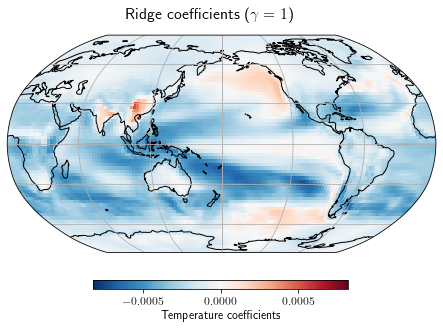

In [46]:
title = "     Ridge coefficients ($\gamma = 1$)"
plots.plotMapCartopy(coefRaw.reshape((72,144)), cLim = None, title = title)

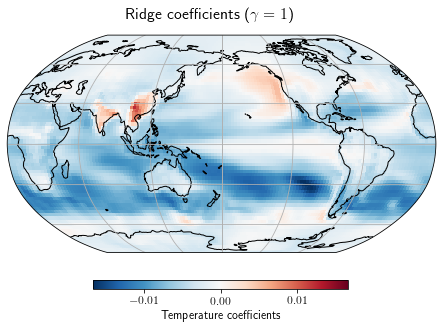

In [6]:
title = "     Ridge coefficients ($\gamma = 1$)"
plots.plotMapCartopy(coefRaw_final.reshape((72,144)), cLim = None, title = title)

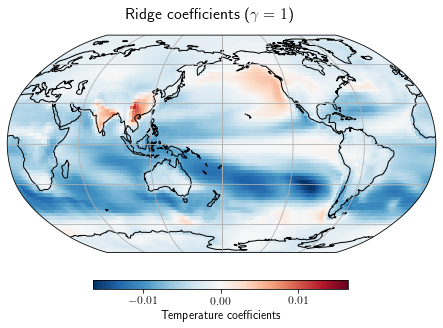

In [8]:
title = "     Ridge coefficients ($\gamma = 1$)"
plots.plotMapCartopy(coefRaw_final.reshape((72,144)), cLim = None, title = title)

In [7]:
nbRuns = 20
coefRaw_final, coefRaw_runs, mse_runs_df, trainFiles, testFiles = anchor_regression.subagging(
    modelsDataList, modelsInfoFrame, params_climate, params_anchor, nbRuns)

---- Run = 0 ----
['BCC' 'CAM' 'CIE' 'Can' 'E3S' 'EC-' 'GIS' 'Had' 'INM' 'KIO' 'MIR' 'MPI'
 'NES' 'Tai']
['ACC' 'AWI' 'CAS' 'CES' 'CMC' 'FGO' 'FIO' 'GFD' 'IIT' 'IPS' 'KAC' 'MCM'
 'MRI' 'Nor' 'SAM']
---- Run = 1 ----
['ACC' 'BCC' 'CAM' 'CIE' 'CMC' 'E3S' 'INM' 'IPS' 'KIO' 'MCM' 'MPI' 'MRI'
 'NES' 'Nor']
['AWI' 'CAS' 'CES' 'Can' 'EC-' 'FGO' 'FIO' 'GFD' 'GIS' 'Had' 'IIT' 'KAC'
 'MIR' 'SAM' 'Tai']
---- Run = 2 ----
['AWI' 'CAS' 'CIE' 'Can' 'EC-' 'FIO' 'GIS' 'Had' 'INM' 'IPS' 'KAC' 'MIR'
 'Nor' 'SAM']
['ACC' 'BCC' 'CAM' 'CES' 'CMC' 'E3S' 'FGO' 'GFD' 'IIT' 'KIO' 'MCM' 'MPI'
 'MRI' 'NES' 'Tai']
---- Run = 3 ----
['AWI' 'BCC' 'CAM' 'CAS' 'EC-' 'FIO' 'Had' 'IIT' 'INM' 'IPS' 'MCM' 'MRI'
 'Nor' 'SAM']
['ACC' 'CES' 'CIE' 'CMC' 'Can' 'E3S' 'FGO' 'GFD' 'GIS' 'KAC' 'KIO' 'MIR'
 'MPI' 'NES' 'Tai']
---- Run = 4 ----
['AWI' 'BCC' 'CAM' 'CAS' 'CES' 'CIE' 'Can' 'E3S' 'EC-' 'GFD' 'KAC' 'MIR'
 'NES' 'Tai']
['ACC' 'CMC' 'FGO' 'FIO' 'GIS' 'Had' 'IIT' 'INM' 'IPS' 'KIO' 'MCM' 'MPI'
 'MRI' 'Nor' 'SAM']
---- Run =

In [9]:
'''  Train files   '''
trainAll = []
for i in range(len(trainFiles)):
    for f in trainFiles[i]:
        mod = f.split("_")[2][:3]
        trainAll.append(mod)

# Option 1    
from collections import Counter
Counter(trainAll)

# Option 2
[[x, trainAll.count(x)] for x in set(trainAll)]

# '''   Test files   '''
# testAll = []
# for i in range(len(testFiles)):
#     for f in testFiles[i]:
#         mod = f.split("_")[2][:3]
#         testAll.append(mod)

# # Option 1    
# from collections import Counter
# Counter(testAll)

# # Option 2
# [[x, testAll.count(x)] for x in set(testAll)]

[['Nor', 60],
 ['MIR', 18],
 ['Had', 24],
 ['FIO', 26],
 ['E3S', 72],
 ['IPS', 20],
 ['GFD', 20],
 ['MRI', 14],
 ['CAM', 28],
 ['CMC', 27],
 ['KAC', 10],
 ['KIO', 12],
 ['Can', 20],
 ['GIS', 70],
 ['CIE', 32],
 ['BCC', 44],
 ['INM', 36],
 ['FGO', 32],
 ['ACC', 28],
 ['MPI', 24],
 ['SAM', 14],
 ['IIT', 16],
 ['Tai', 18],
 ['CAS', 20],
 ['EC-', 104],
 ['MCM', 24],
 ['AWI', 40],
 ['NES', 18],
 ['CES', 80]]